## Import Packages

In [31]:
# Import Python packages
import pandas as pd
import plotly.express as px
import plotly.io as pio
import matplotlib.pyplot as plt
import json
import sys
import cachetools
from datetime import timedelta
import math

# Import Snowflake modules
from snowflake.snowpark import Session
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T
from snowflake.snowpark import Window
from snowflake.ml.modeling.impute import SimpleImputer
from snowflake.ml.modeling.preprocessing import OneHotEncoder
from snowflake.ml.modeling.pipeline import Pipeline
from snowflake.ml.modeling.linear_model import LinearRegression
from snowflake.ml.registry import Registry
from snowflake.ml.modeling.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from snowflake.snowpark.functions import col, to_date

# For display purposes, suppress FutureWarnings and UserWarnings from printing below the cells
import warnings
for warning_category in [FutureWarning, UserWarning]:
    warnings.filterwarnings('ignore', category=warning_category)


## Connect to Snowflake

In [33]:
from snowflake.snowpark.context import get_active_session 
from getpass import getpass

connection_parameters = {
    'account' : "mapbobj-vp47779",
    'user' : 'soojin',
    "password": 'Kimbusan51480501@',

    
    'warehouse' : 'HACKATHON',
    'database' : 'RAW_DATA',
    'schema': 'GRANDATA'
}

# 세션 수동 생성
session = Session.builder.configs(connection_parameters).create()

# # snowflake 세션 연결
# session = get_active_session()

# 쿼리 태그 설정 (추적용)
session.query_tag = {
    'origin': 'digital_nomad_project', # 프로젝트 명
    'name' : 'remote_work_trend_analysis', # 작업 목적
    'version' : {'major' : 1, 'minor' : 0},
    'attributes' : {
        'source' : 'jupyter',
        'analyst' : 'soojin kim '
    }
}

# print the current role, warehouse, and db/schema
print(f"role: {session.get_current_role()} | WH: {session.get_current_warehouse()} | DB.SCHEMA: {session.get_fully_qualified_current_schema()}")

role: "ACCOUNTADMIN" | WH: "HACKATHON" | DB.SCHEMA: "RAW_DATA"."GRANDATA"


In [34]:
from snowflake.snowpark import Session

connection_parameters = {
    "account": "mapbobj-vp47779",
    "user": "soojin",
    "password" : "Kimbusan51480501@",
    "warehouse": "HACKATHON",
    "database": "RAW_DATA",
    "schema": "GRANDATA",
    "authenticator": "snowflake"  # 브라우저 인증 방식
}

# 세션 재연결
session = Session.builder.configs(connection_parameters).create()

# 테이블 다시 불러오기
sales = session.table("CARD_SALES_INFO")
pop = session.table("FLOATING_POPULATION_INFO")


## 데이터 로딩 - Snowflake 테이블 연결

In [36]:
# 테이블 로딩 
card_df = session.table("CARD_SALES_INFO")
float_df = session.table("FLOATING_POPULATION_INFO")
asset_df = session.table("ASSET_INCOME_INFO")
admin_df = session.table("M_SCCO_MST") # GEO 정보는 Panda로 export 후 geopandas로 처리 가능

In [38]:
# 일단 데이터 확인 
# Snowpark DataFrame → Pandas DataFrame
card_df_pd = card_df.to_pandas()
float_df_pd = float_df.to_pandas()
asset_df_pd = asset_df.to_pandas()
admin_df_pd = admin_df.to_pandas()

## 데이터 확인해보기 - 시각화로

In [40]:
# 예시: 상위 5개 행 확인
print(card_df_pd.head())

  PROVINCE_CODE CITY_CODE DISTRICT_CODE STANDARD_YEAR_MONTH CARD_TYPE  \
0            11     11140      11140126              202205         1   
1            11     11140      11140126              202205         1   
2            11     11140      11140126              202205         1   
3            11     11140      11140126              202205         1   
4            11     11140      11140126              202205         1   

  WEEKDAY_WEEKEND GENDER AGE_GROUP TIME_SLOT LIFESTYLE  ...  TRAVEL_COUNT  \
0               W      M        35       T24       L03  ...           0.0   
1               W      F        50       T21       L05  ...           0.0   
2               W      M        35       T24       L01  ...           0.0   
3               W      M        30       T18         *  ...           0.0   
4               H      F        40       T12       L03  ...           0.0   

   BEAUTY_COUNT  HOME_LIFE_SERVICE_COUNT  EDUCATION_ACADEMY_COUNT  \
0           0.0              

In [42]:
# 스키마(컬럼명, 데이터타입) 출력
print("📌 CARD_SALES_INFO schema:")
card_df.print_schema()
print("Total rows:", card_df.count())

print("\n📌 FLOATING_POPULATION_INFO schema:")
float_df.print_schema()
print("Total rows:", float_df.count())

print("\n📌 ASSET_INCOME_INFO schema:")
asset_df.print_schema()
print("Total rows:", asset_df.count())

print("\n📌 M_SCCO_MST schema:")
admin_df.print_schema()
print("Total rows:", admin_df.count())


📌 CARD_SALES_INFO schema:
root
 |-- "PROVINCE_CODE": StringType(2) (nullable = False)
 |-- "CITY_CODE": StringType(5) (nullable = False)
 |-- "DISTRICT_CODE": StringType(8) (nullable = False)
 |-- "STANDARD_YEAR_MONTH": StringType(6) (nullable = False)
 |-- "CARD_TYPE": StringType(1) (nullable = False)
 |-- "WEEKDAY_WEEKEND": StringType(1) (nullable = False)
 |-- "GENDER": StringType(1) (nullable = False)
 |-- "AGE_GROUP": StringType(2) (nullable = False)
 |-- "TIME_SLOT": StringType(3) (nullable = False)
 |-- "LIFESTYLE": StringType(3) (nullable = False)
 |-- "TOTAL_SALES": LongType() (nullable = True)
 |-- "FOOD_SALES": LongType() (nullable = True)
 |-- "COFFEE_SALES": LongType() (nullable = True)
 |-- "ENTERTAINMENT_SALES": LongType() (nullable = True)
 |-- "DEPARTMENT_STORE_SALES": LongType() (nullable = True)
 |-- "LARGE_DISCOUNT_STORE_SALES": LongType() (nullable = True)
 |-- "SMALL_RETAIL_STORE_SALES": LongType() (nullable = True)
 |-- "CLOTHING_ACCESSORIES_SALES": LongType() (n

In [45]:
# 일부 데이터 가져오기
card_sample = card_df.limit(5).to_pandas()
float_sample = float_df.limit(5).to_pandas()
asset_sample = asset_df.limit(5).to_pandas()
admin_sample = admin_df.limit(5).to_pandas()

# 출력
print("\n💳 CARD_SALES_INFO sample:")
print(card_sample)

print("\n👥 FLOATING_POPULATION_INFO sample:")
print(float_sample)

print("\n💰 ASSET_INCOME_INFO sample:")
print(asset_sample)

print("\n🗺️ M_SCCO_MST sample:")
print(admin_sample)



💳 CARD_SALES_INFO sample:
  PROVINCE_CODE CITY_CODE DISTRICT_CODE STANDARD_YEAR_MONTH CARD_TYPE  \
0            11     11140      11140129              202112         1   
1            11     11140      11140129              202112         1   
2            11     11140      11140129              202112         1   
3            11     11140      11140129              202112         1   
4            11     11140      11140129              202112         1   

  WEEKDAY_WEEKEND GENDER AGE_GROUP TIME_SLOT LIFESTYLE  ...  TRAVEL_COUNT  \
0               H      M        30       T15       L01  ...           0.0   
1               W      F        55       T21       L01  ...           0.0   
2               W      M        40       T12       L02  ...           0.0   
3               W      M        60       T15       L04  ...           0.0   
4               W      F        50       T12       L01  ...           0.0   

   BEAUTY_COUNT  HOME_LIFE_SERVICE_COUNT  EDUCATION_ACADEMY_COUNT  \
0 

In [46]:
# Snowpark 테이블 불러오기
card_df = session.table("CARD_SALES_INFO")
float_df = session.table("FLOATING_POPULATION_INFO")
asset_df = session.table("ASSET_INCOME_INFO")
admin_df = session.table("M_SCCO_MST")

# 일부 행만 Pandas DataFrame으로 변환
card_sample = card_df.limit(5).to_pandas()
float_sample = float_df.limit(5).to_pandas()
asset_sample = asset_df.limit(5).to_pandas()
admin_sample = admin_df.limit(5).to_pandas()

# 데이터 확인
import pandas as pd
from IPython.display import display

print("💳 CARD_SALES_INFO Sample")
display(card_sample)

print("👥 FLOATING_POPULATION_INFO Sample")
display(float_sample)

print("💰 ASSET_INCOME_INFO Sample")
display(asset_sample)

print("🗺️ M_SCCO_MST Sample")
display(admin_sample)


💳 CARD_SALES_INFO Sample


,PROVINCE_CODE,CITY_CODE,DISTRICT_CODE,STANDARD_YEAR_MONTH,CARD_TYPE,WEEKDAY_WEEKEND,GENDER,AGE_GROUP,TIME_SLOT,LIFESTYLE,...,TRAVEL_COUNT,BEAUTY_COUNT,HOME_LIFE_SERVICE_COUNT,EDUCATION_ACADEMY_COUNT,MEDICAL_COUNT,ELECTRONICS_FURNITURE_COUNT,CAR_SALES_COUNT,CAR_SERVICE_SUPPLIES_COUNT,GAS_STATION_COUNT,E_COMMERCE_COUNT
0,11,11140,11140129,202112,1,H,M,30,T15,L01,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,11,11140,11140129,202112,1,W,F,55,T21,L01,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,11,11140,11140129,202112,1,W,M,40,T12,L02,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,11,11140,11140129,202112,1,W,M,60,T15,L04,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,11,11140,11140129,202112,1,W,F,50,T12,L01,...,0.0,5.17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


👥 FLOATING_POPULATION_INFO Sample


,PROVINCE_CODE,CITY_CODE,DISTRICT_CODE,STANDARD_YEAR_MONTH,WEEKDAY_WEEKEND,GENDER,AGE_GROUP,TIME_SLOT,RESIDENTIAL_POPULATION,WORKING_POPULATION,VISITING_POPULATION
0,11,11140,11140101,202101,W,M,40,T12,5.27,204.62,120.09
1,11,11140,11140101,202101,H,F,20,T18,0.30,6.46,14.26
2,11,11140,11140101,202101,H,M,40,T12,4.56,15.22,30.69
3,11,11140,11140101,202101,H,M,20,T21,0.48,1.38,4.83
4,11,11140,11140101,202101,H,M,65,T15,1.38,3.04,9.30


💰 ASSET_INCOME_INFO Sample


,PROVINCE_CODE,CITY_CODE,DISTRICT_CODE,STANDARD_YEAR_MONTH,INCOME_TYPE,GENDER,AGE_GROUP,CUSTOMER_COUNT,RATE_MODEL_GROUP_LARGE_COMPANY_EMPLOYEE,RATE_MODEL_GROUP_GENERAL_EMPLOYEE,...,AVERAGE_SCORE,RATE_SCORE1,RATE_SCORE2,RATE_SCORE3,AVERAGE_LOAN_POTENTIAL1,AVERAGE_LOAN_POTENTIAL2,OWN_HOUSING_COUNT,MULTIPLE_HOUSING_COUNT,AVERAGE_ASSET_AMOUNT,RATE_HIGHEND
0,11,11560,11560101,202108,0,F,45,501,0.91,47.00,...,3,77.26,16.70,6.13,222635,-30344,88,27,377309,5.91
1,11,11560,11560101,202108,1,M,40,592,5.84,43.66,...,3,57.56,33.73,6.86,1648186,763775,140,29,407892,13.82
2,11,11560,11560101,202108,1,M,50,804,3.51,35.81,...,4,47.93,40.04,10.31,2599543,1599275,185,50,385991,16.01
3,11,11560,11560101,202108,1,F,35,631,3.07,50.84,...,3,62.86,33.60,2.24,1229941,526744,90,19,354258,5.97
4,11,11560,11560101,202108,1,M,20,448,0.35,14.67,...,5,12.13,84.88,3.06,571829,-222711,4,2,379852,0.92


🗺️ M_SCCO_MST Sample


,PROVINCE_CODE,CITY_CODE,DISTRICT_CODE,PROVINCE_KOR_NAME,CITY_KOR_NAME,DISTRICT_KOR_NAME,PROVINCE_ENG_NAME,CITY_ENG_NAME,DISTRICT_ENG_NAME,DISTRICT_GEOM
0,11,11110,11110101,서울특별시,종로구,청운동,Seoul,Jongno-gu,Cheongun-dong,"{\n ""coordinates"": [\n [\n [\n ..."
1,11,11110,11110102,서울특별시,종로구,신교동,Seoul,Jongno-gu,Singyo-dong,"{\n ""coordinates"": [\n [\n [\n ..."
2,11,11110,11110103,서울특별시,종로구,궁정동,Seoul,Jongno-gu,Gungjeong-dong,"{\n ""coordinates"": [\n [\n [\n ..."
3,11,11110,11110104,서울특별시,종로구,효자동,Seoul,Jongno-gu,Hyoja-dong,"{\n ""coordinates"": [\n [\n [\n ..."
4,11,11110,11110105,서울특별시,종로구,창성동,Seoul,Jongno-gu,Changseong-dong,"{\n ""coordinates"": [\n [\n [\n ..."


In [47]:
# Pandas 옵션 추가 (최상단에 넣어도 좋음)
import pandas as pd
from IPython.display import display

# 👇 이거 추가하면 전체 column, row 다 보임
pd.set_option('display.max_columns', None)  # 컬럼 전체 보기
pd.set_option('display.max_rows', 100)      # 필요 시 100개 정도까지 행 보기
pd.set_option('display.width', None)        # 가로 스크롤 없이 너비 다 보기
pd.set_option('display.max_colwidth', None) # 셀 안 내용 생략 없이 보기

# --- Snowflake 테이블 불러오기 ---
card_df = session.table("CARD_SALES_INFO")
float_df = session.table("FLOATING_POPULATION_INFO")
asset_df = session.table("ASSET_INCOME_INFO")
admin_df = session.table("M_SCCO_MST")

# --- 일부 행만 Pandas DataFrame으로 변환 ---
card_sample = card_df.limit(5).to_pandas()
float_sample = float_df.limit(5).to_pandas()
asset_sample = asset_df.limit(5).to_pandas()
admin_sample = admin_df.limit(5).to_pandas()

# --- 데이터 출력 ---
print("💳 CARD_SALES_INFO Sample")
display(card_sample)

print("👥 FLOATING_POPULATION_INFO Sample")
display(float_sample)

print("💰 ASSET_INCOME_INFO Sample")
display(asset_sample)

print("🗺️ M_SCCO_MST Sample")
display(admin_sample)


💳 CARD_SALES_INFO Sample


,PROVINCE_CODE,CITY_CODE,DISTRICT_CODE,STANDARD_YEAR_MONTH,CARD_TYPE,WEEKDAY_WEEKEND,GENDER,AGE_GROUP,TIME_SLOT,LIFESTYLE,TOTAL_SALES,FOOD_SALES,COFFEE_SALES,ENTERTAINMENT_SALES,DEPARTMENT_STORE_SALES,LARGE_DISCOUNT_STORE_SALES,SMALL_RETAIL_STORE_SALES,CLOTHING_ACCESSORIES_SALES,SPORTS_CULTURE_LEISURE_SALES,ACCOMMODATION_SALES,TRAVEL_SALES,BEAUTY_SALES,HOME_LIFE_SERVICE_SALES,EDUCATION_ACADEMY_SALES,MEDICAL_SALES,ELECTRONICS_FURNITURE_SALES,CAR_SALES,CAR_SERVICE_SUPPLIES_SALES,GAS_STATION_SALES,E_COMMERCE_SALES,TOTAL_COUNT,FOOD_COUNT,COFFEE_COUNT,ENTERTAINMENT_COUNT,DEPARTMENT_STORE_COUNT,LARGE_DISCOUNT_STORE_COUNT,SMALL_RETAIL_STORE_COUNT,CLOTHING_ACCESSORIES_COUNT,SPORTS_CULTURE_LEISURE_COUNT,ACCOMMODATION_COUNT,TRAVEL_COUNT,BEAUTY_COUNT,HOME_LIFE_SERVICE_COUNT,EDUCATION_ACADEMY_COUNT,MEDICAL_COUNT,ELECTRONICS_FURNITURE_COUNT,CAR_SALES_COUNT,CAR_SERVICE_SUPPLIES_COUNT,GAS_STATION_COUNT,E_COMMERCE_COUNT
0,11,11140,11140129,202112,1,H,M,30,T15,L01,7956954,3027922,862684,0,0,0,615612,0,3450736,0,0,0,0,0,0,0,0,0,0,0,258.46,129.23,51.69,0.0,0.0,0.0,51.69,0.00,25.85,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,11,11140,11140129,202112,1,W,F,55,T21,L01,157650,157650,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.34,10.34,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,11,11140,11140129,202112,1,W,M,40,T12,L02,3639917,865269,128705,0,0,0,1049280,0,1596663,0,0,0,0,0,0,0,0,0,0,0,206.76,46.53,10.34,0.0,0.0,0.0,129.22,0.00,20.68,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,11,11140,11140129,202112,1,W,M,60,T15,L04,284287,85286,173157,0,0,0,0,0,0,25844,0,0,0,0,0,0,0,0,0,0,36.19,10.34,20.68,0.0,0.0,0.0,0.00,0.00,0.00,5.17,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,11,11140,11140129,202112,1,W,F,50,T12,L01,483289,356651,0,0,0,0,0,56858,0,0,0,69780,0,0,0,0,0,0,0,0,46.53,36.19,0.00,0.0,0.0,0.0,0.00,5.17,0.00,0.00,0.0,5.17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


👥 FLOATING_POPULATION_INFO Sample


,PROVINCE_CODE,CITY_CODE,DISTRICT_CODE,STANDARD_YEAR_MONTH,WEEKDAY_WEEKEND,GENDER,AGE_GROUP,TIME_SLOT,RESIDENTIAL_POPULATION,WORKING_POPULATION,VISITING_POPULATION
0,11,11140,11140101,202101,W,M,40,T12,5.27,204.62,120.09
1,11,11140,11140101,202101,H,F,20,T18,0.30,6.46,14.26
2,11,11140,11140101,202101,H,M,40,T12,4.56,15.22,30.69
3,11,11140,11140101,202101,H,M,20,T21,0.48,1.38,4.83
4,11,11140,11140101,202101,H,M,65,T15,1.38,3.04,9.30


💰 ASSET_INCOME_INFO Sample


,PROVINCE_CODE,CITY_CODE,DISTRICT_CODE,STANDARD_YEAR_MONTH,INCOME_TYPE,GENDER,AGE_GROUP,CUSTOMER_COUNT,RATE_MODEL_GROUP_LARGE_COMPANY_EMPLOYEE,RATE_MODEL_GROUP_GENERAL_EMPLOYEE,RATE_MODEL_GROUP_PROFESSIONAL_EMPLOYEE,RATE_MODEL_GROUP_EXECUTIVES,RATE_MODEL_GROUP_GENERAL_SELF_EMPLOYED,RATE_MODEL_GROUP_PROFESSIONAL_SELF_EMPLOYED,RATE_MODEL_GROUP_OTHERS,PYEONG_UNDER_20_COUNT,PYEONG_OVER_20_COUNT,PYEONG_OVER_30_COUNT,PYEONG_OVER_40_COUNT,AVERAGE_PRICE_GAP,AVERAGE_LEASE_GAP,AVERAGE_INCOME,AVERAGE_INCOME_OVER_70,AVERAGE_HOUSEHOLD_INCOME,MEDIAN_INCOME,RATE_INCOME_UNDER_20M,RATE_INCOME_20M_TO_30M,RATE_INCOME_30M_TO_40M,RATE_INCOME_40M_TO_50M,RATE_INCOME_50M_TO_60M,RATE_INCOME_60M_TO_70M,RATE_INCOME_OVER_70M,CARD_COUNT,CREDIT_CARD_COUNT,CHECK_CARD_COUNT,AVERAGE_CARD_COUNT,AVERAGE_CREDIT_CARD_COUNT,AVERAGE_CHECK_CARD_COUNT,TOTAL_USAGE_AMOUNT,TOTAL_SALES_USAGE_AMOUNT,TOTAL_FULL_PAYMENT_USAGE_AMOUNT,TOTAL_INSTALLMENT_USAGE_AMOUNT,TOTAL_CASH_ADVANCE_USAGE_AMOUNT,TOTAL_CREDIT_CARD_USAGE_AMOUNT,TOTAL_CHECK_CARD_USAGE_AMOUNT,TOTAL_ABROAD_AMOUNT,AVERAGE_USAGE_AMOUNT,AVERAGE_SALES_USAGE_AMOUNT,AVERAGE_FULL_PAYMENT_USAGE_AMOUNT,AVERAGE_INSTALLMENT_USAGE_AMOUNT,AVERAGE_CASH_ADVANCE_USAGE_AMOUNT,AVERAGE_CREDIT_CARD_USAGE_AMOUNT,AVERAGE_CHECK_CARD_USAGE_AMOUNT,AVERAGE_ABROAD_AMOUNT,AVERAGE_TOTAL_LIMIT_AMOUNT,BALANCE_COUNT,BANK_BALANCE_COUNT,NON_BANK_BALANCE_COUNT,CREDIT_BALANCE_COUNT,HOUSING_BALANCE_COUNT,MORTGAGE1_BALANCE_COUNT,MORTGAGE2_BALANCE_COUNT,AVERAGE_BALANCE_COUNT,AVERAGE_BANK_BALANCE_COUNT,AVERAGE_NON_BANK_BALANCE_COUNT,AVERAGE_CREDIT_BALANCE_COUNT,AVERAGE_HOUSING_BALANCE_COUNT,AVERAGE_MORTGAGE1_BALANCE_COUNT,AVERAGE_MORTGAGE2_BALANCE_COUNT,TOTAL_BALANCE_AMOUNT,TOTAL_BANK_BALANCE_AMOUNT,TOTAL_NON_BANK_BALANCE_AMOUNT,TOTAL_CREDIT_BALANCE_AMOUNT,TOTAL_HOUSING_BALANCE_AMOUNT,TOTAL_MORTGAGE1_BALANCE_AMOUNT,TOTAL_MORTGAGE2_BALANCE_AMOUNT,AVERAGE_BALANCE_AMOUNT,AVERAGE_BANK_BALANCE_AMOUNT,AVERAGE_NON_BANK_BALANCE_AMOUNT,AVERAGE_CREDIT_BALANCE_AMOUNT,AVERAGE_HOUSING_BALANCE_AMOUNT,AVERAGE_MORTGAGE1_BALANCE_AMOUNT,AVERAGE_MORTGAGE2_BALANCE_AMOUNT,NEW_BALANCE_COUNT,NEW_BANK_BALANCE_COUNT,NEW_NON_BANK_BALANCE_COUNT,NEW_CREDIT_BALANCE_COUNT,NEW_HOUSING_BALANCE_COUNT,NEW_MORTGAGE1_BALANCE_COUNT,NEW_MORTGAGE2_BALANCE_COUNT,NEW_TOTAL_BALANCE_AMOUNT,NEW_TOTAL_BANK_BALANCE_AMOUNT,NEW_TOTAL_NON_BANK_BALANCE_AMOUNT,NEW_TOTAL_CREDIT_BALANCE_AMOUNT,NEW_TOTAL_HOUSING_BALANCE_AMOUNT,NEW_TOTAL_MORTGAGE1_BALANCE_AMOUNT,NEW_TOTAL_MORTGAGE2_BALANCE_AMOUNT,DELINQUENT0_COUNT,DELINQUENT30_COUNT,DELINQUENT90_COUNT,AVERAGE_DELINQUENT_COUNT,AVERAGE_DELINQUENT_DAYS,AVERAGE_MAX_DELINQUENT_DAYS,AVERAGE_DELINQUENT_AMOUNT,MEDIAN_DELINQUENT_AMOUNT,AVERAGE_SCORE,RATE_SCORE1,RATE_SCORE2,RATE_SCORE3,AVERAGE_LOAN_POTENTIAL1,AVERAGE_LOAN_POTENTIAL2,OWN_HOUSING_COUNT,MULTIPLE_HOUSING_COUNT,AVERAGE_ASSET_AMOUNT,RATE_HIGHEND
0,11,11560,11560101,202108,0,F,45,501,0.91,47.00,0.09,1.22,16.70,0.87,33.26,17,81,103,29,0.200,1.240,37959,13649,83566,36087,1.04,18.96,52.09,20.61,4.13,2.30,1.09,477,421,449,5,3,2,3329833,2858813,2176612,682201,471019,2930608,399226,14301,6198,5649,4493,1155,550,5395,803,69,58661,198,118,122,148,54,17,7,2,1,2,2,1,0,0,12319628,7728476,4591151,3377764,6794679,73909,226182,54040,67951,13625,12191,75623,230,1639,24,3,21,18,2,1,1,1044091,287000,757091,187091,695000,0,150000,6,5,5,0,92,92,312,185,3,77.26,16.70,6.13,222635,-30344,88,27,377309,5.91
1,11,11560,11560101,202108,1,M,40,592,5.84,43.66,0.49,3.99,8.15,0.67,37.14,2,57,269,7,0.235,1.510,51517,58582,65734,47156,0.52,21.18,22.97,15.23,13.82,8.89,17.32,526,414,501,4,2,2,3628170,3547410,3061615,485794,80760,2900746,727425,43552,5631,5471,4717,755,160,4446,1185,73,48165,280,237,93,215,93,16,10,2,2,1,1,1,1,0,32742088,25261966,7480127,10626310,14776328,77623,861444,92824,79231,46362,42184,83966,1063,11122,15,13,2,13,0,1,0,548149,534479,13670,533249,0,4900,0,6,4,4,0,32,32,772,772,3,57.56,33.73,6.86,1648186,763775,140,29,407892,13.82
2,11,11560,11560101,202108,1,M,50,804,3.51,35.81,0.49,5.13,15.76,0.73,38.60,3,46,304,6,0.

🗺️ M_SCCO_MST Sample


PROVINCE_CODE CITY_CODE DISTRICT_CODE PROVINCE_KOR_NAME CITY_KOR_NAME  \
0            11     11110      11110101             서울특별시           종로구   
1            11     11110      11110102             서울특별시           종로구   
2            11     11110      11110103             서울특별시           종로구   
3            11     11110      11110104             서울특별시           종로구   
4            11     11110      11110105             서울특별시           종로구   

  DISTRICT_KOR_NAME PROVINCE_ENG_NAME CITY_ENG_NAME DISTRICT_ENG_NAME  \
0               청운동             Seoul     Jongno-gu     Cheongun-dong   
1               신교동             Seoul     Jongno-gu       Singyo-dong   
2               궁정동             Seoul     Jongno-gu    Gungjeong-dong   
3               효자동             Seoul     Jongno-gu        Hyoja-dong   
4               창성동             Seoul     Jongno-gu   Changseong-dong   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [48]:
# 원하는 컬럼 리스트
selected_columns = [
    'province_code', 'city_code', 'district_code',
    'standard_year_month', 'card_type', 'weekday_weekend',
    'gender', 'age_group', 'time_slot', 'lifestyle',
    'total_sales', 'coffee_sales', 'total_count', 'coffee_count'
]

# 컬럼 선택해서 Snowpark DataFrame → Pandas DataFrame
card_selected_df = card_df.select(selected_columns).to_pandas()

# 출력 (DataFrame 형식)
from IPython.display import display
display(card_selected_df)


,PROVINCE_CODE,CITY_CODE,DISTRICT_CODE,STANDARD_YEAR_MONTH,CARD_TYPE,WEEKDAY_WEEKEND,GENDER,AGE_GROUP,TIME_SLOT,LIFESTYLE,TOTAL_SALES,COFFEE_SALES,TOTAL_COUNT,COFFEE_COUNT
0,11,11140,11140101,202201,1,W,F,70,T12,L06,4699480,222857,194.68,20.49
1,11,11140,11140101,202201,1,W,F,45,T18,L03,2337700,0,97.33,0.00
2,11,11140,11140101,202201,1,W,F,35,T12,L03,13755699,579942,1009.25,56.36
3,11,11140,11140101,202201,1,W,M,30,T06,L03,21005,0,20.49,0.00
4,11,11140,11140101,202201,1,W,F,45,T21,L03,423686,0,66.60,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3742989,11,11650,11650104,202208,1,H,F,35,T15,L02,3917393,62330,111.49,10.13
3742990,11,11650,11650104,202208,1,H,M,20,T18,L01,2973069,79052,91.22,5.07
3742991,11,11650,11650104,202208,1,W,M,55,T09,L05,35641489,0,912.13,0.00
3742992,11,11650,11650104,202208,1,W,F,40,T21,L03,3543375,0,60.81,0.00


### 보기 쉬운 value로 바꾸기
- TIME_SLOT, LIFESTYLE 열

In [50]:
# 시간대 매핑 딕셔너리 (CODE_ID == 'M03')
time_slot_map = {
    'T06': '아침',
    'T09': '오전',
    'T12': '점심',
    'T15': '오후',
    'T18': '저녁',
    'T21': '심야',
    'T24': '기타'
}

# 라이프스타일 매핑 딕셔너리 (CODE_ID == 'M06')
lifestyle_map = {
    'L01': '싱글',
    'L02': '신혼부부',
    'L03': '영유아가족',
    'L04': '청소년가족',
    'L05': '성인자녀가족',
    'L06': '실버'
}

# 딕셔너리를 이용한 값 치환
card_selected_df['TIME_SLOT'] = card_selected_df['TIME_SLOT'].replace(time_slot_map)
card_selected_df['LIFESTYLE'] = card_selected_df['LIFESTYLE'].replace(lifestyle_map)

from IPython.display import display
display(card_selected_df.head())



,PROVINCE_CODE,CITY_CODE,DISTRICT_CODE,STANDARD_YEAR_MONTH,CARD_TYPE,WEEKDAY_WEEKEND,GENDER,AGE_GROUP,TIME_SLOT,LIFESTYLE,TOTAL_SALES,COFFEE_SALES,TOTAL_COUNT,COFFEE_COUNT
0,11,11140,11140101,202201,1,W,F,70,점심,실버,4699480,222857,194.68,20.49
1,11,11140,11140101,202201,1,W,F,45,저녁,영유아가족,2337700,0,97.33,0.00
2,11,11140,11140101,202201,1,W,F,35,점심,영유아가족,13755699,579942,1009.25,56.36
3,11,11140,11140101,202201,1,W,M,30,아침,영유아가족,21005,0,20.49,0.00
4,11,11140,11140101,202201,1,W,F,45,심야,영유아가족,423686,0,66.60,0.00


### 동네 명칭도 바꾸기 

In [52]:
# 1. Snowflake에서 m_scco_mst 테이블 불러오기
mst_df = session.table("M_SCCO_MST").to_pandas()

# 2. 매핑용 딕셔너리 생성
city_map = dict(zip(mst_df['CITY_CODE'], mst_df['CITY_KOR_NAME']))
district_map = dict(zip(mst_df['DISTRICT_CODE'], mst_df['DISTRICT_KOR_NAME']))

# 3. 컬럼 타입을 str로 변환 (안 하면 KeyError 날 수 있음)
card_selected_df['CITY_CODE'] = card_selected_df['CITY_CODE'].astype(str)
card_selected_df['DISTRICT_CODE'] = card_selected_df['DISTRICT_CODE'].astype(str)

# 4. 값 치환
card_selected_df['CITY_CODE'] = card_selected_df['CITY_CODE'].replace(city_map)
card_selected_df['DISTRICT_CODE'] = card_selected_df['DISTRICT_CODE'].replace(district_map)

card_selected_df = card_selected_df.rename(columns={
    'CITY_CODE': 'CITY_NAME',
    'DISTRICT_CODE': 'DISTRICT_NAME'
})

from IPython.display import display
display(card_selected_df[['CITY_NAME', 'DISTRICT_NAME']].head())



,CITY_NAME,DISTRICT_NAME
0,중구,무교동
1,중구,무교동
2,중구,무교동
3,중구,무교동
4,중구,무교동


In [53]:
display(card_selected_df.head())

,PROVINCE_CODE,CITY_NAME,DISTRICT_NAME,STANDARD_YEAR_MONTH,CARD_TYPE,WEEKDAY_WEEKEND,GENDER,AGE_GROUP,TIME_SLOT,LIFESTYLE,TOTAL_SALES,COFFEE_SALES,TOTAL_COUNT,COFFEE_COUNT
0,11,중구,무교동,202201,1,W,F,70,점심,실버,4699480,222857,194.68,20.49
1,11,중구,무교동,202201,1,W,F,45,저녁,영유아가족,2337700,0,97.33,0.00
2,11,중구,무교동,202201,1,W,F,35,점심,영유아가족,13755699,579942,1009.25,56.36
3,11,중구,무교동,202201,1,W,M,30,아침,영유아가족,21005,0,20.49,0.00
4,11,중구,무교동,202201,1,W,F,45,심야,영유아가족,423686,0,66.60,0.00


### year, month로 분리

In [55]:
# 문자열로 변환 (혹시 숫자형일 수도 있으니)
card_selected_df['STANDARD_YEAR_MONTH'] = card_selected_df['STANDARD_YEAR_MONTH'].astype(str)

# 연도, 월 분리
card_selected_df['YEAR'] = card_selected_df['STANDARD_YEAR_MONTH'].str[:4]
card_selected_df['MONTH'] = card_selected_df['STANDARD_YEAR_MONTH'].str[4:6]

display(card_selected_df[['STANDARD_YEAR_MONTH', 'YEAR', 'MONTH']].head())



,STANDARD_YEAR_MONTH,YEAR,MONTH
0,202201,2022,01
1,202201,2022,01
2,202201,2022,01
3,202201,2022,01
4,202201,2022,01


In [56]:
display(card_selected_df.head())

,PROVINCE_CODE,CITY_NAME,DISTRICT_NAME,STANDARD_YEAR_MONTH,CARD_TYPE,WEEKDAY_WEEKEND,GENDER,AGE_GROUP,TIME_SLOT,LIFESTYLE,TOTAL_SALES,COFFEE_SALES,TOTAL_COUNT,COFFEE_COUNT,YEAR,MONTH
0,11,중구,무교동,202201,1,W,F,70,점심,실버,4699480,222857,194.68,20.49,2022,01
1,11,중구,무교동,202201,1,W,F,45,저녁,영유아가족,2337700,0,97.33,0.00,2022,01
2,11,중구,무교동,202201,1,W,F,35,점심,영유아가족,13755699,579942,1009.25,56.36,2022,01
3,11,중구,무교동,202201,1,W,M,30,아침,영유아가족,21005,0,20.49,0.00,2022,01
4,11,중구,무교동,202201,1,W,F,45,심야,영유아가족,423686,0,66.60,0.00,2022,01


In [57]:
# 기존 컬럼 제거
card_selected_df = card_selected_df.drop(columns=['STANDARD_YEAR_MONTH', 'PROVINCE_CODE'])

In [58]:
display(card_selected_df.head())

,CITY_NAME,DISTRICT_NAME,CARD_TYPE,WEEKDAY_WEEKEND,GENDER,AGE_GROUP,TIME_SLOT,LIFESTYLE,TOTAL_SALES,COFFEE_SALES,TOTAL_COUNT,COFFEE_COUNT,YEAR,MONTH
0,중구,무교동,1,W,F,70,점심,실버,4699480,222857,194.68,20.49,2022,01
1,중구,무교동,1,W,F,45,저녁,영유아가족,2337700,0,97.33,0.00,2022,01
2,중구,무교동,1,W,F,35,점심,영유아가족,13755699,579942,1009.25,56.36,2022,01
3,중구,무교동,1,W,M,30,아침,영유아가족,21005,0,20.49,0.00,2022,01
4,중구,무교동,1,W,F,45,심야,영유아가족,423686,0,66.60,0.00,2022,01


## 시각화

In [60]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# macOS 기본 한글 폰트 설정 (AppleGothic이 가장 무난함)
mpl.rc('font', family='AppleGothic')

# 마이너스 부호 깨짐 방지
mpl.rcParams['axes.unicode_minus'] = False


#### 1. 월별 카드 소비 추이

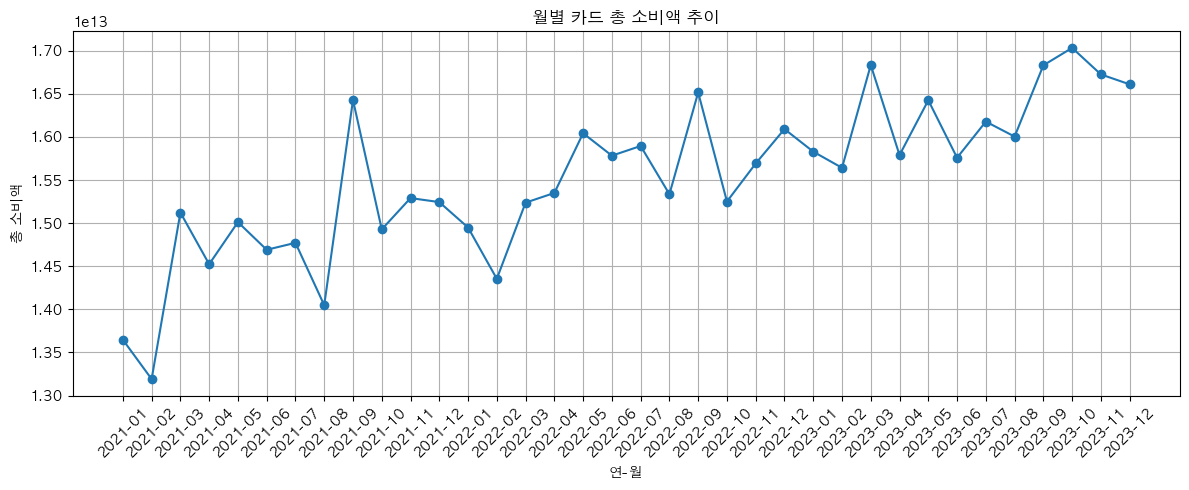

In [62]:
import matplotlib.pyplot as plt

# 연-월 기준 월별 소비 집계
monthly_sales = card_selected_df.groupby(['YEAR', 'MONTH'])['TOTAL_SALES'].sum().reset_index()
monthly_sales['YM'] = monthly_sales['YEAR'].astype(str) + '-' + monthly_sales['MONTH'].astype(str).str.zfill(2)

# 시각화
plt.figure(figsize=(12, 5))
plt.plot(monthly_sales['YM'], monthly_sales['TOTAL_SALES'], marker='o')
plt.xticks(rotation=45)
plt.title("월별 카드 총 소비액 추이")
plt.xlabel("연-월")
plt.ylabel("총 소비액")
plt.grid(True)
plt.tight_layout()
plt.show()


### 2. 성별 + 연령대별 소비 비교

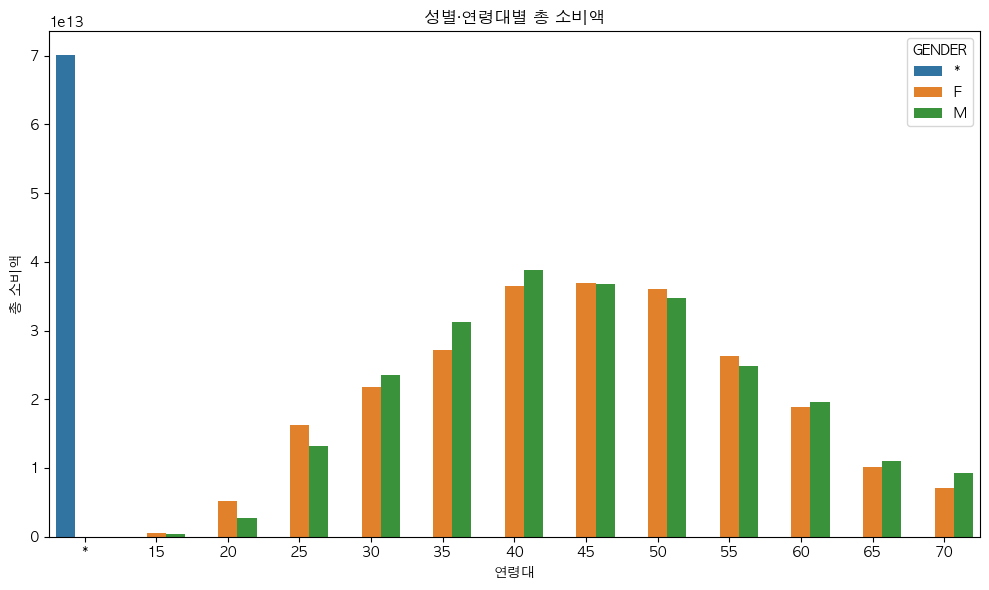

In [64]:
import seaborn as sns

# 집계
age_gender_sales = card_selected_df.groupby(['GENDER', 'AGE_GROUP'])['TOTAL_SALES'].sum().reset_index()

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(data=age_gender_sales, x='AGE_GROUP', y='TOTAL_SALES', hue='GENDER')
plt.title("성별·연령대별 총 소비액")
plt.xlabel("연령대")
plt.ylabel("총 소비액")
plt.tight_layout()
plt.show()


### 3. 시간대별 커피 소비량 분석

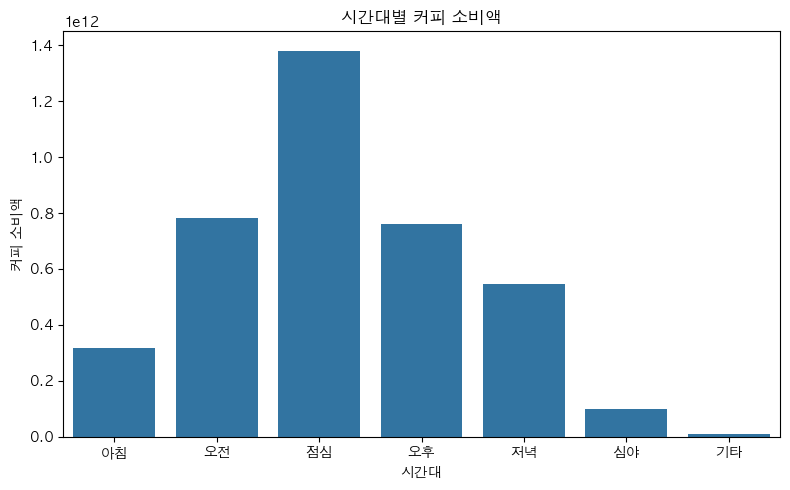

In [66]:
time_coffee = card_selected_df.groupby('TIME_SLOT')['COFFEE_SALES'].sum().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(data=time_coffee, x='TIME_SLOT', y='COFFEE_SALES', order=['아침', '오전', '점심', '오후', '저녁', '심야', '기타'])
plt.title("시간대별 커피 소비액")
plt.xlabel("시간대")
plt.ylabel("커피 소비액")
plt.tight_layout()
plt.show()


#### 4. 라이프 스타일별 커피 소비 비교

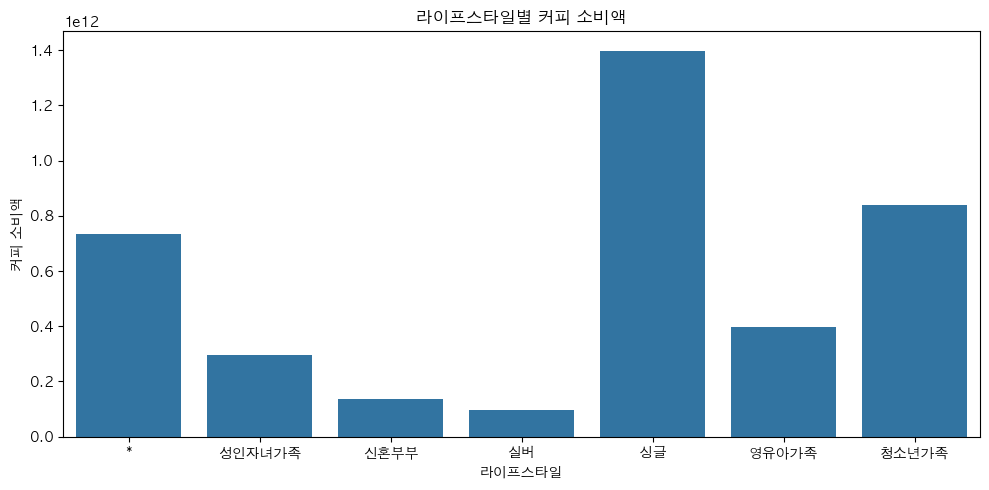

In [68]:
lifestyle_coffee = card_selected_df.groupby('LIFESTYLE')['COFFEE_SALES'].sum().reset_index()

plt.figure(figsize=(10, 5))
sns.barplot(data=lifestyle_coffee, x='LIFESTYLE', y='COFFEE_SALES')
plt.title("라이프스타일별 커피 소비액")
plt.xlabel("라이프스타일")
plt.ylabel("커피 소비액")
plt.tight_layout()
plt.show()
